In [109]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split,GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
import imblearn
from prince import FAMD

import pickle

from xgboost import XGBClassifier

In [2]:
sns.set_style('whitegrid')

In [3]:
df_mailout = pd.read_parquet('data/refined/full_mailout_train_data_final.parquet')

In [4]:
df_mailout.shape

(35007, 303)

# Response variable

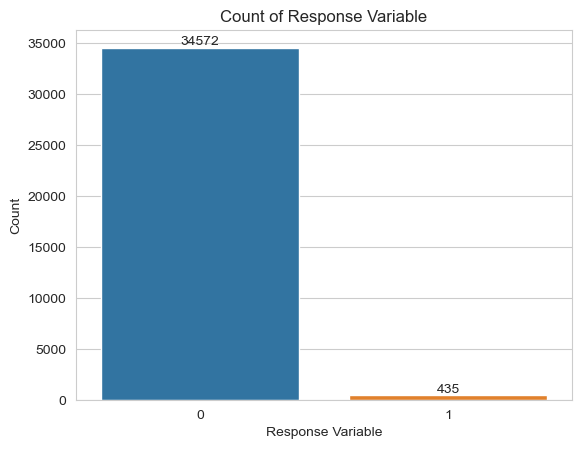

In [5]:
g = sns.countplot(data = df_mailout,
                    x = 'RESPONSE')

g.bar_label(g.containers[-1])

plt.title('Count of Response Variable')

plt.ylabel('Count')

plt.xlabel('Response Variable')

plt.show()

In [6]:
df_mailout['RESPONSE'].value_counts(normalize = True)

0    0.987574
1    0.012426
Name: RESPONSE, dtype: float64

The data is HEAVILY imbalanced. A little more than 1% actually responded to the mailing.  
This is not inherently bad. Some methods can be used like up- or downsampling but not necessairly.  
Either way, given this hard imbalace, accuracy should not be used since in this context it is a biased metric

# Segmenting variable types

In [7]:
census_var_types = pd.read_csv('data/trusted/var_type_list.csv')

In [8]:
census_var_types.head()

,Attribute,Type,dtype
0,AGER_TYP,nominal,int
1,ALTERSKATEGORIE_GROB,interval,int
2,ALTER_HH,interval,int
3,ANREDE_KZ,binary,int
4,ANZ_HAUSHALTE_AKTIV,numeric,float


In [9]:
binary_vars = census_var_types[census_var_types['Type'] == 'binary']['Attribute'].values

binary_vars = np.intersect1d(binary_vars, df_mailout.columns)

In [10]:
for col in binary_vars:
    
    try:
        print(col, df_mailout[col].unique())

    except:

        print(f'Column not found: {col}')

        continue

ANREDE_KZ [2 1]
ANZ_HH_TITEL [0 1]
ANZ_KINDER [0 1]
GREEN_AVANTGARDE [0 1]
KBA05_SEG6 [0 1]
OST_WEST_KZ [1 0]
VERS_TYP [2 1]


In [11]:
df_mailout['ANREDE_KZ'] = df_mailout['ANREDE_KZ'] - 1

df_mailout['VERS_TYP'] = df_mailout['VERS_TYP'] - 1

In [12]:
nominal_vars = census_var_types[census_var_types['Type'] == 'nominal']['Attribute'].values

nominal_vars = np.intersect1d(nominal_vars, df_mailout.columns)

In [13]:
interval_vars = census_var_types[census_var_types['Type'] == 'interval']['Attribute'].values

interval_vars = np.intersect1d(interval_vars, df_mailout.columns)

In [14]:
binary_vars = census_var_types[census_var_types['Type'] == 'binary']['Attribute'].values

binary_vars = np.intersect1d(binary_vars, df_mailout.columns)

In [15]:
num_cols = df_mailout.columns.drop(list(nominal_vars) + list(binary_vars) + list(interval_vars) + ['LNR','RESPONSE'])

In [16]:
assert (len(nominal_vars) + len(binary_vars) + len(interval_vars) + len(num_cols) + 1) == len(df_mailout.columns.drop('RESPONSE'))

# Splitting Data

In [17]:
X = df_mailout.drop(columns = ['LNR','RESPONSE']).reset_index(drop = True)

y = df_mailout['RESPONSE'].reset_index(drop = True)

In [18]:
feature_list = df_mailout.columns.drop(['LNR','RESPONSE'])

nominal_vars_pos = [feature_list.get_loc(col) for col in X.columns if col in nominal_vars]

interval_vars_pos = [feature_list.get_loc(col) for col in X.columns if col in interval_vars]

num_vars_pos = [feature_list.get_loc(col) for col in X.columns if col in num_cols]

In [19]:
df_mailout[interval_vars] = df_mailout[interval_vars].astype(int)

In [42]:
for col in nominal_vars:

    if col == 'D19_LETZTER_KAUF_BRANCHE_RZ':

        continue

    df_mailout[col] = df_mailout[col].astype(int)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify = y,random_state=42)

In [21]:
y_train.value_counts(normalize = True)

0    0.987574
1    0.012426
Name: RESPONSE, dtype: float64

In [22]:
y_test.value_counts(normalize = True)

0    0.987575
1    0.012425
Name: RESPONSE, dtype: float64

# Testing base models
Vanilla models to pick best option for tuning

In [23]:
# Models to be tested
dt = DecisionTreeClassifier(max_depth=3, class_weight='balanced')

rf = RandomForestClassifier(max_depth = 3,class_weight='balanced_subsample',random_state=42, n_jobs=-1)

# Instantiating an XGB to match the closest possible characteristics with balanced class_weights
xgb = XGBClassifier(scale_pos_weight = 80,
                    max_depth = 2,
                    eta = 0.1,
                    n_jobs = -1,
                    random_state = 42,
                    objective = 'binary:logistic',
                    eval_metric = 'auc' )

# Baseline
lr = LogisticRegression(n_jobs = -1,class_weight='balanced',random_state=42)

Initial models with a few parameters to avoid overfitting.  
Comparison Baseline: Logistic Regression

In [24]:
transformer_no_ohe_interval = make_column_transformer(
                                                        (StandardScaler(), list(interval_vars) + list(num_cols)),
                                                        (OneHotEncoder(),sorted(nominal_vars_pos)),
                                                        remainder = 'passthrough'
                                                        )

transformer_ohe_interval = make_column_transformer(
                                                    (StandardScaler(), num_vars_pos),
                                                    (OneHotEncoder(handle_unknown = 'ignore'), sorted(nominal_vars_pos + interval_vars_pos)), #  Using LE for imblearn purposes
                                                    remainder = 'passthrough'
                                                    )

In [25]:
# Models to be tested
pipe_dt = Pipeline([('scaler_ohe',transformer_no_ohe_interval),('DT',dt)])

pipe_rf = Pipeline([('scaler_ohe',transformer_no_ohe_interval),('RF',rf)])

# Instantiating an XGB to match the closest possible characteristics with balanced class_weights
pipe_xgb = Pipeline([('scaler_ohe',transformer_no_ohe_interval),('XGB',xgb)])

pipe_lr = Pipeline([('scaler_ohe',transformer_no_ohe_interval),('LR',lr)])

In [26]:
models_dict = {'Decision Tree':pipe_dt, 'Random Forest':pipe_rf,'XGBoost':pipe_xgb, 'LogisticRegression':pipe_lr}

In [27]:
skfold = StratifiedKFold(n_splits = 5)

In [28]:
def evaluate_models(X,y,dict_models,cv):

    for i, (name, model) in enumerate(dict_models.items()):

        scores = cross_validate(model, X, y, cv=cv, scoring='roc_auc', n_jobs= -1, verbose = 1, return_train_score=True)

        scores['model'] = name

        if i == 0:

            records = [scores]

        else:

            records.append(scores)

    for i, r in enumerate(records):

        temp = pd.DataFrame.from_dict(r)

        if i == 0:

            results_df = temp
        
        else:

            results_df = pd.concat([results_df, temp])
        
    results_df.reset_index(inplace = True)

    results_df.rename(columns = {'index':'Fold'}, inplace = True)

    return results_df

## Testing interval vars w/o OHE

In [29]:
results_df = evaluate_models(X_train, y_train, dict_models = models_dict, cv = skfold)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.5s remaining:   14.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.8s remaining:   10.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   19.8s remaining:   29.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.2s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.3s finished


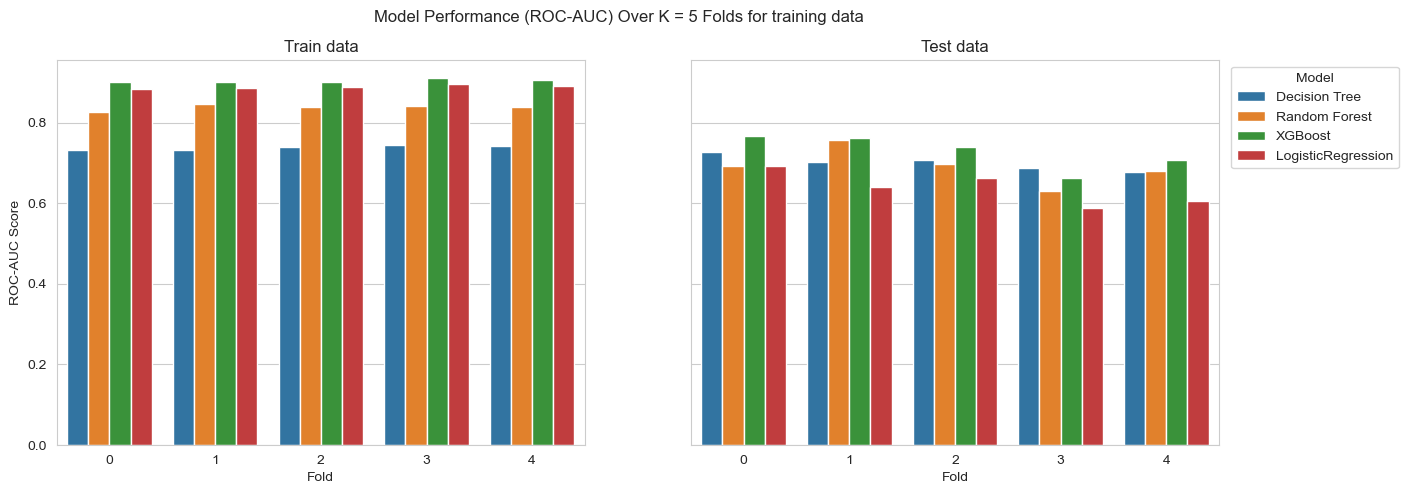

In [30]:
fig, ax = plt.subplots(1,2,figsize = (15,5), sharey=True)

sns.barplot(data = results_df,
                    x = 'Fold',
                    y = 'train_score',
                    hue = 'model',
                    ax = ax[0])

sns.barplot(data = results_df,
                    x = 'Fold',
                    y = 'test_score',
                    hue = 'model',
                    ax = ax[1])

ax[0].set_ylabel('ROC-AUC Score')

ax[0].get_legend().remove()

ax[0].set_title('Train data')

ax[1].set_title('Test data')

ax[1].legend(title = 'Model',bbox_to_anchor = (1.01,1), loc = 'upper left')

ax[1].set_ylabel('')

for a in ax:

    a.set_xlabel('Fold')

plt.suptitle('Model Performance (ROC-AUC) Over K = 5 Folds for training data')

plt.show()

In [31]:
results_df.groupby('model')[['test_score','train_score']].mean()

,test_score,train_score
model,,
Decision Tree,0.700377,0.738477
LogisticRegression,0.637067,0.889336
Random Forest,0.691386,0.838235
XGBoost,0.728122,0.903537


Due to the difference between train and test set performance, the models seem to overfit on training data.  
This is somewhat expected, since there is a heavy unbalance in data.

## Testing interval vars w/ OHE

In [32]:
# Models to be tested
pipe_dt_ohe_int = Pipeline([('scaler_ohe',transformer_ohe_interval),('DT',dt)])

pipe_rf_ohe_int = Pipeline([('scaler_ohe',transformer_ohe_interval),('RF',rf)])

# Instantiating an XGB to match the closest possible characteristics with balanced class_weights
pipe_xgb_ohe_int = Pipeline([('scaler_ohe',transformer_ohe_interval),('XGB',xgb)])

pipe_lr_ohe_int = Pipeline([('scaler_ohe',transformer_ohe_interval),('LR',lr)])

In [33]:
models_dict_ohe_interval = {'Decision Tree':pipe_dt_ohe_int,
                            'Random Forest':pipe_rf_ohe_int,
                            'XGBoost':pipe_xgb_ohe_int,
                            'LogisticRegression':pipe_lr_ohe_int}

In [34]:
results_df = evaluate_models(X_train, y_train, dict_models = models_dict_ohe_interval, cv = skfold)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.1s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.4s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   18.5s remaining:   27.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.2s remaining:   15.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.4s finished


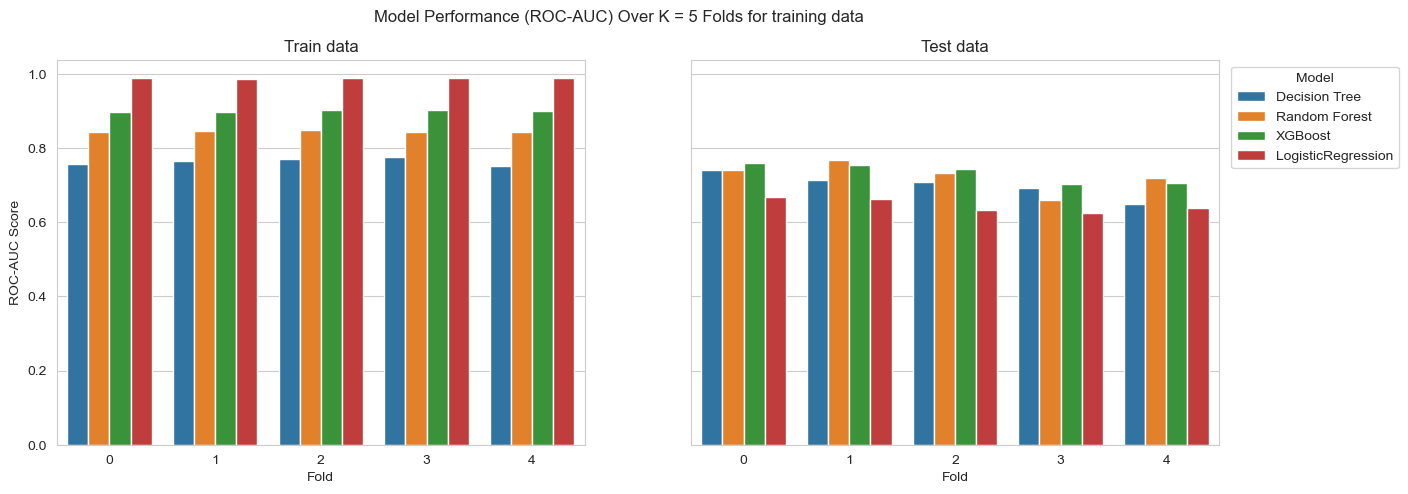

In [35]:
fig, ax = plt.subplots(1,2,figsize = (15,5), sharey=True)

sns.barplot(data = results_df,
                    x = 'Fold',
                    y = 'train_score',
                    hue = 'model',
                    ax = ax[0])

sns.barplot(data = results_df,
                    x = 'Fold',
                    y = 'test_score',
                    hue = 'model',
                    ax = ax[1])

ax[0].set_ylabel('ROC-AUC Score')

ax[0].get_legend().remove()

ax[0].set_title('Train data')

ax[1].set_title('Test data')

ax[1].legend(title = 'Model',bbox_to_anchor = (1.01,1), loc = 'upper left')

ax[1].set_ylabel('')

for a in ax:

    a.set_xlabel('Fold')

plt.suptitle('Model Performance (ROC-AUC) Over K = 5 Folds for training data')

plt.show()

In [36]:
results_df.groupby('model')[['test_score','train_score']].mean()

,test_score,train_score
model,,
Decision Tree,0.701264,0.763959
LogisticRegression,0.645299,0.989073
Random Forest,0.724597,0.845105
XGBoost,0.733472,0.900662


# Testing models with dimensionality reduction
Taking input from clustering notebook

In [37]:
famd = FAMD(n_components=225,
            random_state = 123,
            handle_unknown = 'ignore')

X_train_transformed = famd.fit_transform(X_train)

c:\Users\Lucca\anaconda3\envs\arvato\lib\site-packages\prince\famd.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  eta2[col] = (
c:\Users\Lucca\anaconda3\envs\arvato\lib\site-packages\prince\famd.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  eta2[col] = (
c:\Users\Lucca\anaconda3\envs\arvato\lib\site-packages\prince\famd.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

In [38]:
van_models_dict = {'Decision Tree':dt,
                   'Random Forest':rf,
                   'XGBoost':xgb,
                   'LogisticRegression':lr}

In [39]:
result_df_vanilla = evaluate_models(X_train_transformed, y_train, dict_models = van_models_dict, cv = skfold)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.0s remaining:   18.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.6s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.2min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.0s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


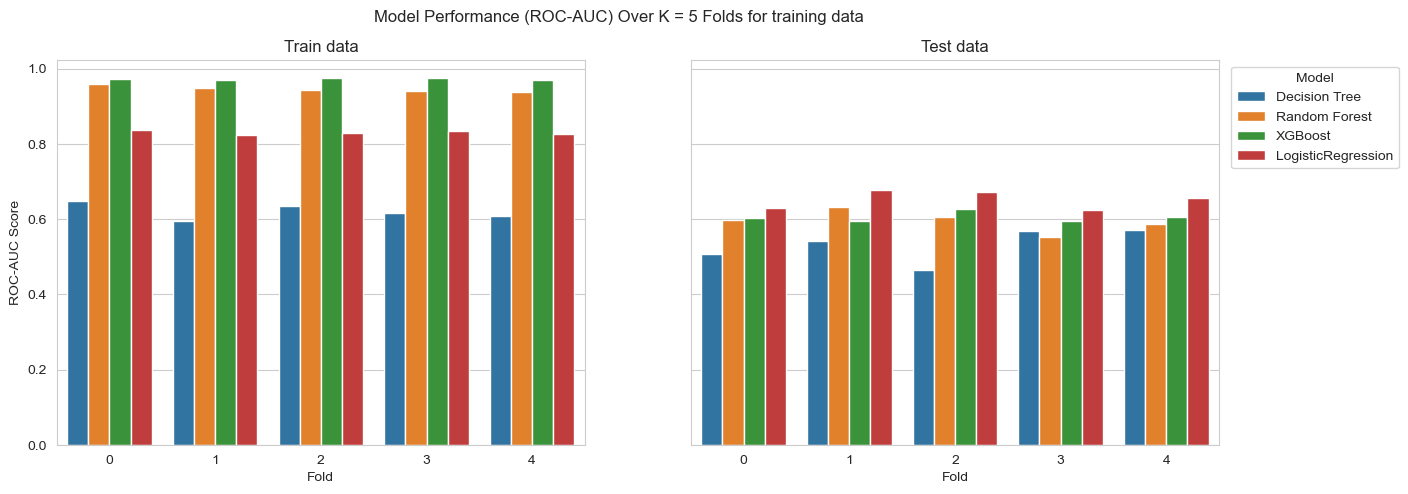

In [40]:
fig, ax = plt.subplots(1,2,figsize = (15,5), sharey=True)

sns.barplot(data = result_df_vanilla,
                    x = 'Fold',
                    y = 'train_score',
                    hue = 'model',
                    ax = ax[0])

sns.barplot(data = result_df_vanilla,
                    x = 'Fold',
                    y = 'test_score',
                    hue = 'model',
                    ax = ax[1])

ax[0].set_ylabel('ROC-AUC Score')

ax[0].get_legend().remove()

ax[0].set_title('Train data')

ax[1].set_title('Test data')

ax[1].legend(title = 'Model',bbox_to_anchor = (1.01,1), loc = 'upper left')

ax[1].set_ylabel('')

for a in ax:

    a.set_xlabel('Fold')

plt.suptitle('Model Performance (ROC-AUC) Over K = 5 Folds for training data')

plt.show()

In [41]:
result_df_vanilla.groupby('model')[['test_score','train_score']].mean()

,test_score,train_score
model,,
Decision Tree,0.530523,0.620180
LogisticRegression,0.651986,0.830229
Random Forest,0.594337,0.945603
XGBoost,0.605149,0.971923


Dimensionality reduction seems to have made the results even worse on the test scores and lead to higher overfitting

# Hyperparameter Tuning - Variables with OHE

In [58]:
dt_params = {'DT__max_depth':[5,6,7,8],
             'DT__min_samples_split':[2,5,10],
             'DT__min_samples_leaf':[3,5]}

xgb_params = {'XGB__n_estimators':[100,150,200],
              'XGB__max_depth':[2,3],
              'XGB__learning_rate':[0.1,0.2,0.3],
              'XGB__scale_pos_weight':[80,0],
              'XGB__alpha':[0,1,2.5]}

In [59]:
# model_search_list = list(zip([pipe_dt, pipe_rf, pipe_xgb],
#                                 [dt_params, rf_params, xgb_params],
#                                 ['DT','RF','XGB']))

model_search_list = list(zip([pipe_dt, pipe_xgb],
                                [dt_params, xgb_params],
                                ['DT','XGB']))

In [60]:
cross_vals = {'DT':None,
        #       'RF':None,
              'XGB':None}

for model, params, name in model_search_list:

    print(f'Running for {name}')

    cv = RandomizedSearchCV(model,
                            params,
                            scoring = 'roc_auc',
                            n_jobs = -1,
                            cv = skfold,
                            verbose = 1)
        
    cv.fit(X_train, y_train)

    print('Mean Scores:',cv.cv_results_['mean_test_score'],'\n',
            'Rank:',cv.cv_results_['rank_test_score'], end = '\n\n')
    
    cross_vals[name] = cv

Running for DT
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mean Scores: [0.6299969  0.63022067 0.64590451 0.6454933  0.65244223 0.64539603
 0.63076504 0.64973081 0.64933289 0.65231528] 
 Rank: [10  9  5  6  1  7  8  3  4  2]

Running for XGB
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[15:56:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "n_thread" } are not used.

Mean Scores: [0.64110114 0.62371198 0.5        0.5        0.65177933 0.5
 0.5        0.5        0.5        0.64727329] 
 Rank: [3 4 5 5 1 5 5 5 5 2]



Baseline values for XGB were different from DT. Looking with more depth in XGB

In [62]:
grid_cv = GridSearchCV(pipe_xgb,
                        params,
                        scoring = 'roc_auc',
                        n_jobs = -1,
                        cv = skfold,
                        verbose = 1)

grid_cv.fit(X_train, y_train)

print('Mean Scores:',grid_cv.cv_results_['mean_test_score'],'\n',
            'Rank:',grid_cv.cv_results_['rank_test_score'], end = '\n\n')

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[17:22:37] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "n_thread" } are not used.

Mean Scores: [0.6724409  0.5        0.66588324 0.5        0.66248366 0.5
 0.66557084 0.5        0.65844821 0.5        0.65371087 0.5
 0.67512573 0.5        0.66246682 0.5        0.65817902 0.5
 0.65656719 0.5        0.64459865 0.5        0.64055168 0.5
 0.65295137 0.5        0.65338518 0.5        0.64961028 0.5
 0.63106281 0.5        0.62694295 0.5        0.62371198 0.5
 0.67391957 0.5        0.66953672 0.5        0.66077279 0.5
 0.66656032 0.5        0.66220405 0.5        0.65536324 0.5
 0.66173125 0.5        0.65177933 0.5        0.64859156 0.5
 0.66439437 0.5        0.65191093 0.5        0.64727329 0.5
 0.65837488 0.5        0.65407245 0.5        0.65263853 0.5
 0.64990938 0.5        0.63839592 0.5        0.63219586 0.5
 0.67516606 0.5        0.66964927 0.5        0.65915808 0.5
 0

In [63]:
grid_cv.best_params_

{'XGB__alpha': 2.5,
 'XGB__learning_rate': 0.1,
 'XGB__max_depth': 2,
 'XGB__n_estimators': 100,
 'XGB__scale_pos_weight': 80}

In [66]:
grid_cv.best_score_

0.6751660573834053

In [67]:
# with open(f'models/XGB_no_interval_ohe_best_estimator.pkl', 'wb') as file:

#             pickle.dump(grid_cv.best_estimator_, file)

In [49]:
# for c in cross_vals.values():

#         with open(f'models/{name}_best_estimator.pkl', 'wb') as file:

#                 pickle.dump(c.best_estimator_, file)

# Hyperparameter Tuning - RF with OHE of interval vars

In [113]:
rf_params = {'RF__n_estimators':[100,200,300],
             'RF__max_depth':[2,3]}

xgb_params = {'XGB__n_estimators':[100],
              'XGB__max_depth':[2,3],
              'XGB__learning_rate':[0.1,0.2,0.3],
              'XGB__alpha':[0,1,2.5]}

In [114]:
model_search_list_alt = list(zip([pipe_rf_ohe_int, pipe_xgb_ohe_int],
                                [rf_params, xgb_params],
                                ['RF','XGB']))

In [115]:
cross_vals_alt = {'RF':None,
                   'XGB':None}

for model, params, name in model_search_list_alt: 

    print(f'Running for {name}')

    cv = GridSearchCV(model,
                        params,
                        scoring = 'roc_auc',
                        n_jobs = -1,
                        cv = skfold,
                        verbose = 1)
        
    cv.fit(X_train, y_train)

    print('Mean Scores:',cv.cv_results_['mean_test_score'],'\n',
            'Rank:',cv.cv_results_['rank_test_score'], end = '\n\n')
    
    cross_vals[name] = cv

Running for RF
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mean Scores: [0.67514523 0.67820317 0.67675994 0.68171087 0.6800319  0.67754293] 
 Rank: [6 3 5 1 2 4]

Running for XGB
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[11:51:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "n_thread" } are not used.

Mean Scores: [0.66742041 0.65967165 0.64988634 0.64980304 0.64367121 0.6435303
 0.67213847 0.66207156 0.65025014 0.64610701 0.6371295  0.63239216
 0.67192866 0.65662524 0.64791138 0.65807378 0.64171308 0.64312042] 
 Rank: [ 3  5  9 10 13 14  1  4  8 12 17 18  2  7 11  6 16 15]



In [124]:
# with open(f'models/RF_interval_ohe_best_estimator.pkl', 'wb') as file:

#   pickle.dump(cross_vals['RF'].best_estimator_, file)

# Predictions on test set

In [112]:
import os

In [114]:
model_dict = {}

for m in os.listdir('models'):

    if 'clusters' in m:

        continue

    else:

        name = m.split('_')[0]

        with open(os.path.join('models',m), 'rb') as file:

            model_dict[name] = pickle.load(file)

In [138]:
models_dict = {}

for m in ['RF_interval_ohe_best_estimator', 'XGB_no_interval_ohe_best_estimator']:

    key = m.split('_')[0]

    with  open(f'models/{m}.pkl', 'rb') as file:

        model = pickle.load(file)

        models_dict[key] = model

In [139]:
# Baseline Result
models_dict['LR'] = pipe_lr

In [185]:
model_result_dict = {'model':[],
                     'auc_score':[]}

curve_data = []

for name, model in models_dict.items():

    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_test)[:, 1]
    
    score_auc = roc_auc_score(y_test, y_pred)

    fpr, tpr, thresh = roc_curve(y_test, y_pred)

    curve_data.append((name, fpr, tpr, thresh))

    model_result_dict['model'].append(name)

    model_result_dict['auc_score'].append(score_auc)
    
model_result_frame = pd.DataFrame().from_dict(model_result_dict)

model_curve_data = pd.DataFrame(curve_data, columns = ['Model','FPR','TPR','Thresholds']).explode(['FPR','TPR','Thresholds'])

[12:55:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "n_thread" } are not used.



# Result Plot

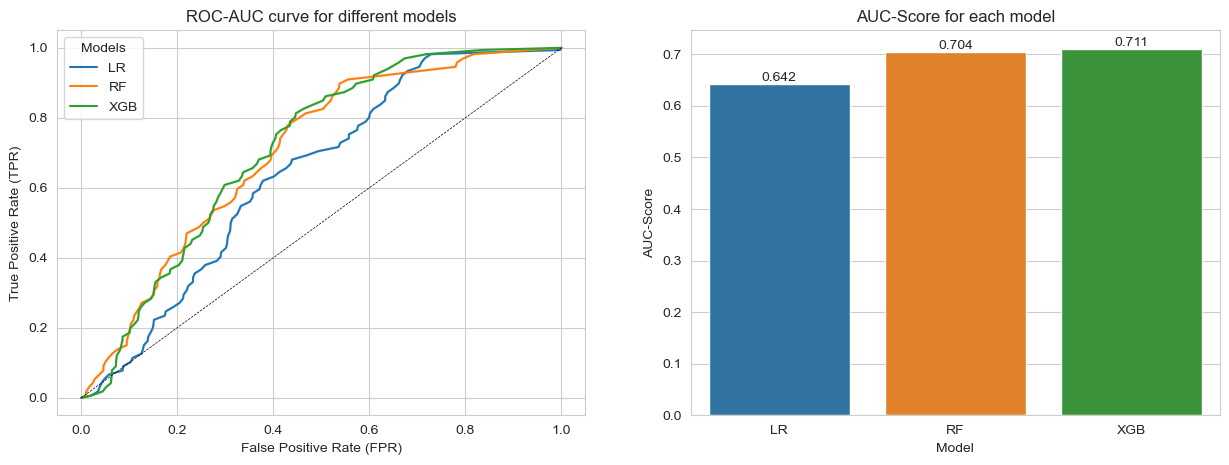

In [203]:
fig, axs = plt.subplots(1,2,figsize = (15,5))

sns.lineplot(data = model_curve_data,
             x = 'FPR',
             y = 'TPR',
             hue = 'Model',
             ax = axs[0],
             errorbar=('ci',0),
             hue_order=['LR','RF','XGB'])

# Reference for ROC-AUC Plot
sns.lineplot(x = [0,1],
             y = [0,1],
             linestyle = '--',
             color = 'black',
             linewidth = 0.5,
             ax = axs[0])

sns.barplot(data = model_result_frame,
            x = 'model',
            y = 'auc_score',
            hue = 'model',
            hue_order = ['LR','RF','XGB'],
            order = ['LR','RF','XGB'],
            ax = axs[1],
            dodge=False)

axs[0].set_title('ROC-AUC curve for different models')

# plt.legend(title = 'Models')

axs[0].set_xlabel('False Positive Rate (FPR)')

axs[0].set_ylabel('True Positive Rate (TPR)')

axs[0].legend(title = 'Models')

for bars in axs[1].containers: axs[1].bar_label(bars, fmt='%.3f')

axs[1].set_title('AUC-Score for each model')

axs[1].set_ylabel('AUC-Score')

axs[1].set_xlabel('Model')

axs[1].get_legend().remove()

plt.show()